In [1]:
!pip install -U scikit-learn
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import networkx as nx
import hdbscan
from itertools import combinations

In [3]:
sklearn.__version__

'1.5.1'

# Hierarchical Density Based Spatial Clustering for Analysis with Noise

**First, with a synthetic dataset**

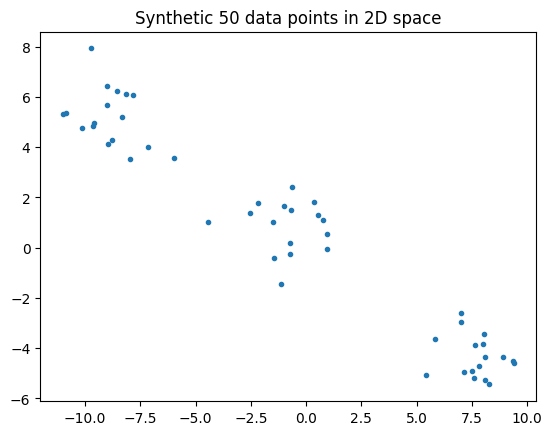

In [4]:
X, labels = make_blobs(n_samples=50, centers=3, random_state=29)

plt.plot(X[:,0], X[:,1], '.')
plt.title('Synthetic 50 data points in 2D space');

In [5]:
# set minimum points
minPts = 5

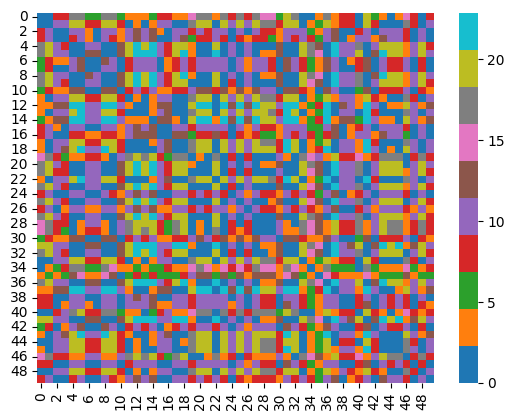

In [6]:
distmat = pairwise_distances(X)
sns.heatmap(distmat, cmap='tab10');

In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=minPts, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(gen_min_span_tree=True)

# Step 1: Core distance

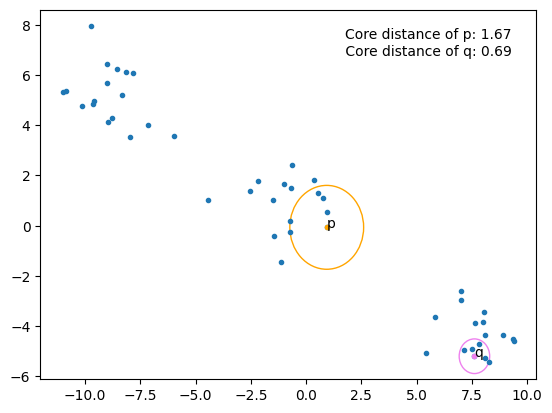

In [8]:
p = 16
q = 20
corep = np.round(np.sort(distmat[p,:])[minPts], 2)
coreq = np.round(np.sort(distmat[q,:])[minPts], 2)
plt.plot(X[:,0], X[:,1], '.')

plt.plot(X[p,0], X[p,1], '.', color='orange')
plt.text(X[p,0], X[p,1], 'p')
circlep = Circle(xy=(X[p,0], X[p,1]), radius=corep, edgecolor='orange', facecolor='none')

plt.plot(X[q,0], X[q,1], '.', color='violet')
plt.text(X[q,0], X[q,1], 'q')
circleq = Circle(xy=(X[q,0], X[q,1]), radius=coreq, edgecolor='violet', facecolor='none')

plt.gca().add_artist(circlep)
plt.gca().add_artist(circleq)
plt.text(0.95, 0.95, f'Core distance of p: {corep}\n Core distance of q: {coreq}',
         transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='top');

# Step 2: Mutual reachability distance

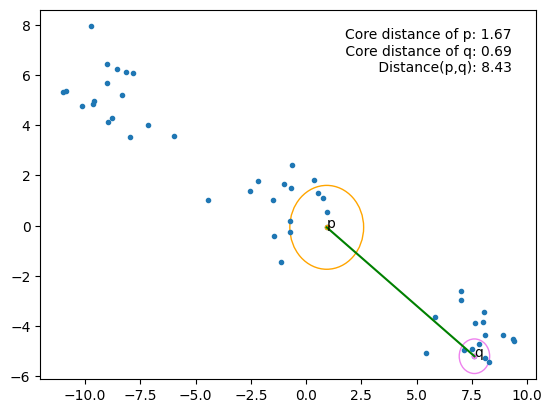

In [9]:
p = 16
q = 20
plt.plot(X[:,0], X[:,1], '.')

plt.plot(X[p,0], X[p,1], '.', color='orange')
plt.text(X[p,0], X[p,1], 'p')
circlep = Circle(xy=(X[p,0], X[p,1]), radius=np.sort(distmat[p,:])[5], edgecolor='orange', facecolor='none')

plt.plot(X[q,0], X[q,1], '.', color='violet')
plt.text(X[q,0], X[q,1], 'q')
circleq = Circle(xy=(X[q,0], X[q,1]), radius=np.sort(distmat[q,:])[5], edgecolor='violet', facecolor='none')

plt.gca().add_artist(circlep)
plt.gca().add_artist(circleq)

plt.plot((X[p,0], X[q,0]), (X[p,1], X[q,1]), color='green')
distpq = np.round(distmat[p,q], 2)
plt.text(0.95, 0.95,
         f'Core distance of p: {corep}\n Core distance of q: {coreq}\n Distance(p,q): {distpq}',
         transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='top');

In [10]:
def mutual_reach_dist(pairpoints, distmat_=distmat, minpts=minPts) -> float:
    '''pairpoints: a pair of points we want to measure (not the point coords)'''
    p0, p1 = pairpoints
    core_p0 = np.round(np.sort(distmat[p0,:])[minpts], 2)
    core_p1 = np.round(np.sort(distmat[p1,:])[minpts], 2)
    dist_p0p1 = np.round(distmat_[p0, p1], 2)
    return np.max([core_p0, core_p1, dist_p0p1])

In [11]:
edgelist = []
for pair in combinations(np.arange(50), 2):
    #convert a tuple to a list
    points = list(pair)
    
    #add the mutual reachability distance as 'weight'
    points.append(mutual_reach_dist(pair))
    
    #append the weighted edge list (for visualization)
    edgelist.append(tuple(points))

norm_mutual_dist = np.array([i[2] for i in edgelist])
norm_mutual_dist = norm_mutual_dist/np.max(norm_mutual_dist)

In [12]:
len(norm_mutual_dist)

1225

## The output of step 2

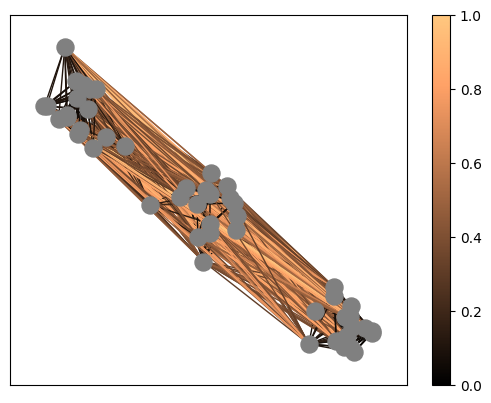

In [13]:
G = nx.Graph()
G.add_nodes_from(np.arange(50))
G.add_weighted_edges_from(edgelist, weight='mutual_reachability_distance')

nodes = nx.draw_networkx_nodes(G, pos={k:v for (k,v) in zip(np.arange(50), X)},
                               node_size=150, node_color='gray')
edges = nx.draw_networkx_edges(G, pos={k:v for k,v in zip(np.arange(50), X)},
                               edge_color=norm_mutual_dist, edge_cmap=plt.cm.copper)
plt.colorbar(matplotlib.cm.ScalarMappable(cmap=plt.cm.copper), ax=plt.gca());

# Step 3: Minimum Spanning Tree

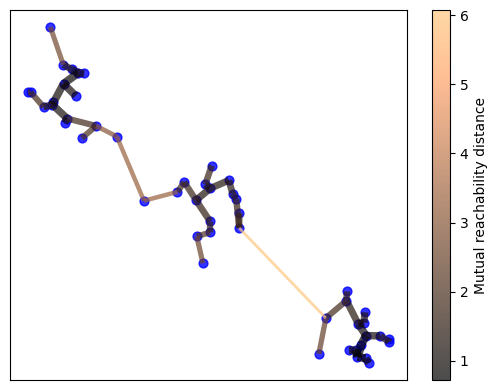

In [14]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='copper', edge_alpha=0.7,
                                      node_color='blue');

# Step 4: Single linkage dendrogram

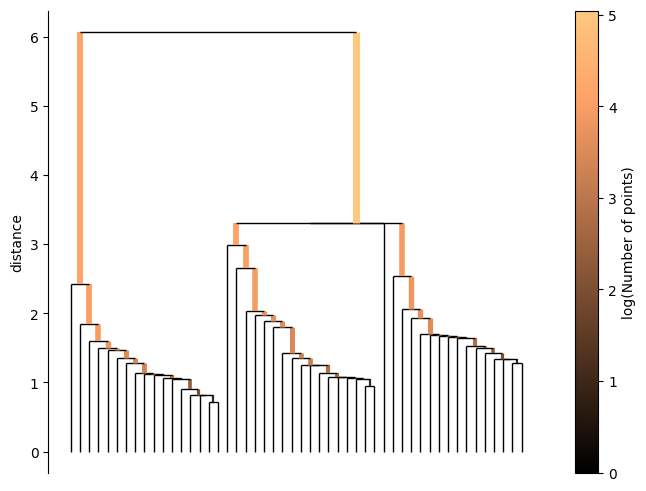

In [15]:
plt.figure(figsize=(8,6))
clusterer.single_linkage_tree_.plot(cmap=plt.cm.copper, colorbar=True);

# Step 5: Condense the single linkage tree

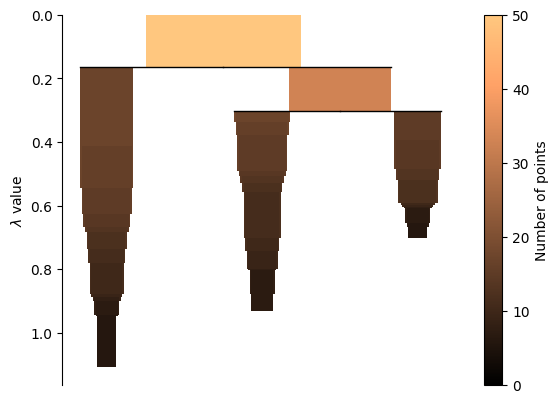

In [16]:
clusterer.condensed_tree_.plot(cmap='copper');

# Step 6: Select the clusters

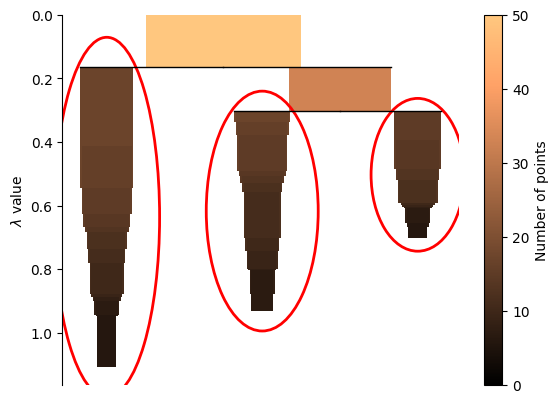

In [17]:
clusterer.condensed_tree_.plot(cmap='copper', select_clusters=True);